In [1]:
import maxflow
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import argparse

In [2]:
class GraphCuts:
    """
    Main class for image synthesis with graph cuts
    """
    def __init__(self, src, sink, mask, save_graph=False):
        """
        Initializes the graph and computes the min-cut.
        :param src: image to be blended (foreground)
        :param sink: background image
        :param mask: manual mask with constrained pixels
        :param save_graph: if true, graph is saved
        """
        assert (src.shape == sink.shape), \
            f"Source and sink dimensions must be the same: {str(src.shape)} != {str(sink.shape)}"

        # Create the graph
        graph = maxflow.Graph[float]()
        # Add the nodes. node_ids has the identifiers of the nodes in the grid.
        node_ids = graph.add_grid_nodes((src.shape[0], src.shape[1]))

        self.compute_edge_weights(src, sink)

        # Add non-terminal edges
        # TODO: use alternate API which is more efficient
        patch_height = src.shape[0]
        patch_width = src.shape[1]
        for row_idx in range(patch_height):
            for col_idx in range(patch_width):
                # right neighbor
                if col_idx + 1 < patch_width:
                    weight = self.edge_weights[row_idx, col_idx, 0]
                    graph.add_edge(node_ids[row_idx][col_idx],
                                   node_ids[row_idx][col_idx + 1],
                                   weight,
                                   weight)

                # bottom neighbor
                if row_idx + 1 < patch_height:
                    weight = self.edge_weights[row_idx, col_idx, 1]
                    graph.add_edge(node_ids[row_idx][col_idx],
                                   node_ids[row_idx + 1][col_idx],
                                   weight,
                                   weight)

                # Add terminal edge capacities for the pixels constrained to
                # belong to the source/sink.
                if np.array_equal(mask[row_idx, col_idx, :], [0, 255, 255]):
                    graph.add_tedge(node_ids[row_idx][col_idx], 0, np.inf)
                elif np.array_equal(mask[row_idx, col_idx, :], [255, 128, 0]):
                    graph.add_tedge(node_ids[row_idx][col_idx], np.inf, 0)

        # Plot graph
        if save_graph:
            nxg = graph.get_nx_graph()
            self.plot_graph_2d(nxg, patch_height, patch_width)

        # Compute max flow / min cut.
        flow = graph.maxflow()
        self.sgm = graph.get_grid_segments(node_ids)

    def compute_edge_weights(self, src, sink):
        """
        Computes edge weights based on matching quality cost.
        :param src: image to be blended (foreground)
        :param sink: background image
        """
        self.edge_weights = np.zeros((src.shape[0], src.shape[1], 2))

        # Create shifted versions of the matrices for vectorized operations.
        src_left_shifted = np.roll(src, -1, axis=1)
        sink_left_shifted = np.roll(sink, -1, axis=1)
        src_up_shifted = np.roll(src, -1, axis=0)
        sink_up_shifted = np.roll(sink, -1, axis=0)

        # Assign edge weights.
        # For numerical stability, avoid divide by 0.
        eps = 1e-10

        # Right neighbor.
        weight = np.sum(np.square(src - sink, dtype=np.float) +
                        np.square(src_left_shifted - sink_left_shifted, 
                        dtype=np.float),
                        axis=2)
        norm_factor = np.sum(np.square(src - src_left_shifted, dtype=np.float) +
                             np.square(sink - sink_left_shifted, 
                             dtype=np.float),
                             axis=2)
        self.edge_weights[:, :, 0] = weight / (norm_factor + eps)

        # Bottom neighbor.
        weight = np.sum(np.square(src - sink, dtype=np.float) +
                        np.square(src_up_shifted - sink_up_shifted,
                        dtype=np.float),
                        axis=2)
        norm_factor = np.sum(np.square(src - src_up_shifted, dtype=np.float) +
                             np.square(sink - sink_up_shifted, 
                             dtype=np.float),
                             axis=2)
        self.edge_weights[:, :, 1] = weight / (norm_factor + eps)

    def plot_graph_2d(self, graph, nodes_shape, plot_weights=False, 
                      plot_terminals=True, font_size=7):
        """
        Plot the graph to be used in graph cuts
        :param graph: PyMaxflow graph
        :param nodes_shape: patch shape
        :param plot_weights: if true, edge weights are shown
        :param plot_terminals: if true, the terminal nodes are shown
        :param font_size: text font size
        """
        X, Y = np.mgrid[:nodes_shape[0], :nodes_shape[1]]
        aux = np.array([Y.ravel(), X[::-1].ravel()]).T
        positions = {i: v for i, v in enumerate(aux)}
        positions['s'] = (-1, nodes_shape[0] / 2.0 - 0.5)
        positions['t'] = (nodes_shape[1], nodes_shape[0] / 2.0 - 0.5)

        nxgraph = graph.get_nx_graph()
        print("nxgraph created")
        if not plot_terminals:
            nxgraph.remove_nodes_from(['s', 't'])

        plt.clf()
        nx.draw(nxgraph, pos=positions)

        if plot_weights:
            edge_labels = {}
            for u, v, d in nxgraph.edges(data=True):
                edge_labels[(u, v)] = d['weight']
            nx.draw_networkx_edge_labels(nxgraph,
                                         pos=positions,
                                         edge_labels=edge_labels,
                                         label_pos=0.3,
                                         font_size=font_size)

        plt.axis('equal')
        plt.show()

    def blend(self, src, target):
        """
        Blends the target image with the source image based on the graph cut.
        :param src: Source image
        :param target: Target image
        """
        target[self.sgm] = src[self.sgm]
        return target
    
    def blendy(self, src):
        """
        Blends the target image with the source image based on the graph cut.
        :param src: Source image
        :param target: Target image
        """
        return src[self.sgm]

In [3]:
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('-i', dest='image_dir', required=True, help='Image directory')
#     args = parser.parse_args()

#     # Read the images and the mask.
#     image_dir = args.image_dir

image_dir = r"C:\Users\lucki\WORK\UMBC\DAA\DAA_641-Spring_22-Project_1\images\hut"
src = cv2.imread(os.path.join(image_dir, 'src.jpg'))
target = cv2.imread(os.path.join(image_dir, 'target.jpg'))
mask = cv2.imread(os.path.join(image_dir, 'mask.png'))

In [4]:
# Compute the min-cut.
graphcuts = GraphCuts(src, target, mask);

C:\Users\lucki\WORK\Anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\lucki\WORK\Anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\lucki\WORK\Anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:84: Deprec

In [5]:
# Save the output.
target = graphcuts.blend(src, target)

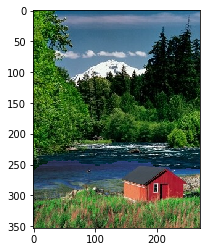

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# plt.imshow(target,cmap='prism')

rgb_img = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_img)
plt.show()

## Test

In [7]:
graphcuts.plot_graph_2d

<bound method GraphCuts.plot_graph_2d of <__main__.GraphCuts object at 0x0000019E344187C8>>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

res = graphcuts.sgm
res

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
rgb_img = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_img)
plt.show()

In [ ]:
# cv2.imwrite(os.path.join(image_dir, "result.png"), target)

In [17]:
import maxflow
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_dir = r"C:\Users\lucki\WORK\UMBC\DAA\DAA_641-Spring_22-Project_1\images\hut"
src = cv2.imread(os.path.join(image_dir, 'src.jpg'))
sink = cv2.imread(os.path.join(image_dir, 'target.jpg'))
mask = cv2.imread(os.path.join(image_dir, 'mask.png'))

In [6]:
def compute_edge_weights(src, sink):
    """
    Computes edge weights based on matching quality cost.
    :param src: image to be blended (foreground)
    :param sink: background image
    """
    edge_weights = np.zeros((src.shape[0], src.shape[1], 2))

    # Create shifted versions of the matrices for vectorized operations.
    src_left_shifted = np.roll(src, -1, axis=1)
    sink_left_shifted = np.roll(sink, -1, axis=1)
    src_up_shifted = np.roll(src, -1, axis=0)
    sink_up_shifted = np.roll(sink, -1, axis=0)

    # Assign edge weights.
    # For numerical stability, avoid divide by 0.
    eps = 1e-10

    # Right neighbor.
    weight = np.sum(np.square(src - sink, dtype=np.float) +
                    np.square(src_left_shifted - sink_left_shifted, 
                    dtype=np.float),
                    axis=2)
    norm_factor = np.sum(np.square(src - src_left_shifted, dtype=np.float) +
                         np.square(sink - sink_left_shifted, 
                         dtype=np.float),
                         axis=2)
    edge_weights[:, :, 0] = weight / (norm_factor + eps)

    # Bottom neighbor.
    weight = np.sum(np.square(src - sink, dtype=np.float) +
                    np.square(src_up_shifted - sink_up_shifted,
                    dtype=np.float),
                    axis=2)
    norm_factor = np.sum(np.square(src - src_up_shifted, dtype=np.float) +
                         np.square(sink - sink_up_shifted, 
                         dtype=np.float),
                         axis=2)
    edge_weights[:, :, 1] = weight / (norm_factor + eps)
    
    return edge_weights

In [7]:
assert (src.shape == sink.shape), f"Source and sink dimensions must be the same: {str(src.shape)} != {str(sink.shape)}"

# Create the graph
graph = maxflow.Graph[float]()
# Add the nodes. node_ids has the identifiers of the nodes in the grid.
node_ids = graph.add_grid_nodes((src.shape[0], src.shape[1]))

edge_weights = compute_edge_weights(src, sink)

In [9]:
# Add non-terminal edges
patch_height = src.shape[0]
patch_width = src.shape[1]
for row_idx in range(patch_height):
    for col_idx in range(patch_width):
        # right neighbor
        if col_idx + 1 < patch_width:
            weight = edge_weights[row_idx, col_idx, 0]
            graph.add_edge(node_ids[row_idx][col_idx],
                           node_ids[row_idx][col_idx + 1],
                           weight,
                           weight)

        # bottom neighbor
        if row_idx + 1 < patch_height:
            weight = edge_weights[row_idx, col_idx, 1]
            graph.add_edge(node_ids[row_idx][col_idx],
                           node_ids[row_idx + 1][col_idx],
                           weight,
                           weight)

        # Add terminal edge capacities for the pixels constrained to
        # belong to the source/sink.
        if np.array_equal(mask[row_idx, col_idx, :], [0, 255, 255]):
            graph.add_tedge(node_ids[row_idx][col_idx], 0, np.inf)
        elif np.array_equal(mask[row_idx, col_idx, :], [255, 128, 0]):
            graph.add_tedge(node_ids[row_idx][col_idx], np.inf, 0)

In [11]:
# Compute max flow / min cut.
flow = graph.maxflow()

In [13]:
sgm = graph.get_grid_segments(node_ids)

In [12]:
flow

12.058232585748879

In [15]:
x = src[sgm]

In [36]:
x.shape

(27995, 3)

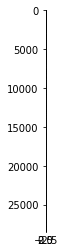

In [19]:
rgb_img = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_img)
plt.show()

# Some Plotting of ndarray

In [29]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [46]:
import numpy as np
# from IPython import imshow


imshow(x*255)
